<a href="https://colab.research.google.com/github/JackHalliwill/ML_Assignment1/blob/main/jh8vn_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file.

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [8]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
file_path = './insurance.csv'

stats = os.stat(file_path)
MB = stats.st_size / (1024*1024)
print("File size is " + str(MB) + " MB")

with open(file_path, 'r') as table:
    reader=csv.reader(table)
    entries = 0
    i = 0
    catData = False
    for row in reader:
        if i != 0:
            entries += len(row)
            if catData == False:
                for entry in row:
                    if isinstance(entry, str) or isinstance(entry, bool):
                        catData = True
        else:
            numOfFeatures = len(row)
        
        i+=1
    print("Total number of entries is " + str(entries))
    print("Total number of features is " + str(numOfFeatures))
    print("Is there catagorical data: " + str(catData))

df = pd.read_csv(file_path)

missing = df.isnull()
if True in missing:
    print("Yes there is missing data")
else:
    print("No data is missing from the table")

# Some statistics I can see right away:
#   Most charges in 5-15k range
#   Sex does not seem to be a good indicator
#   If the charges are > 20k, they person is generally > 40 years old

File size is 0.053050994873046875 MB
Total number of entries is 9366
Total number of features is 7
Is there catagorical data: True
No data is missing from the table


---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class.

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

The male count is 676 (50.52316890881914%) and female is 662 (49.47683109118087%)
The smoker count is 274 (20.47832585949178%) and nonsmoker is 1064 (79.52167414050822%)


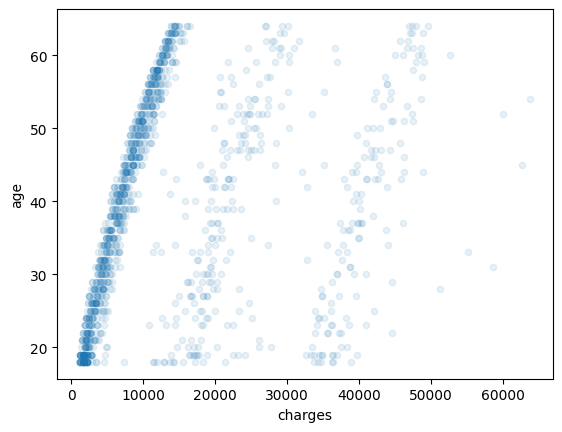

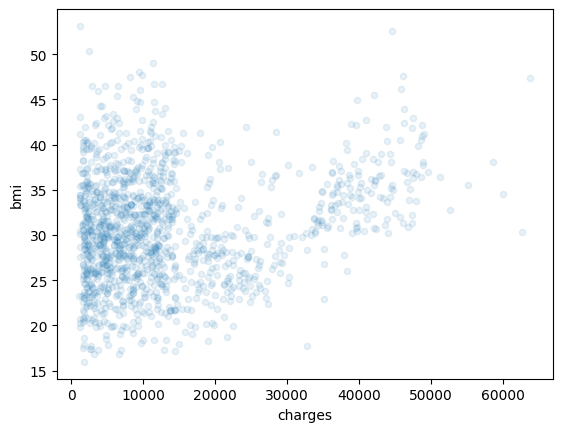

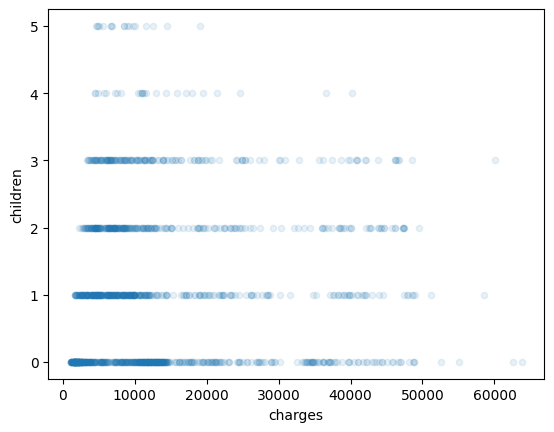

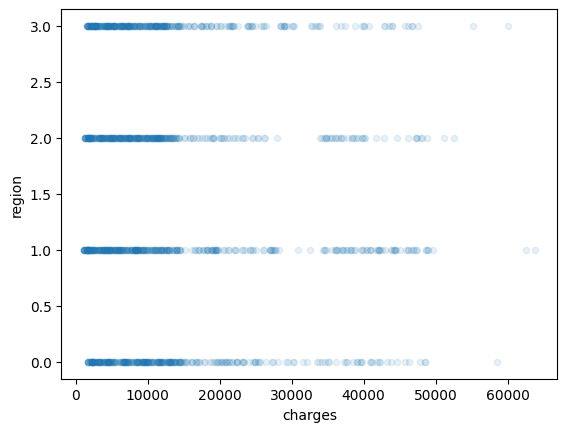

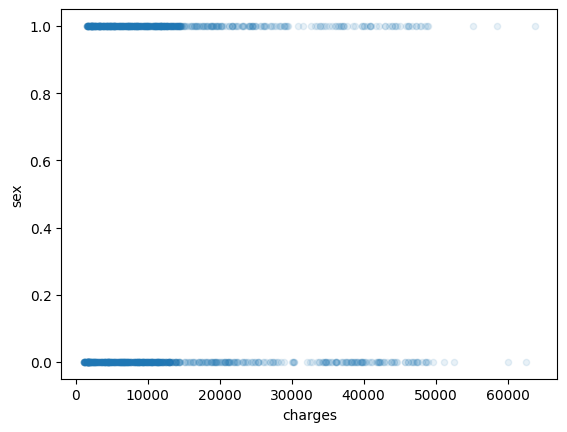

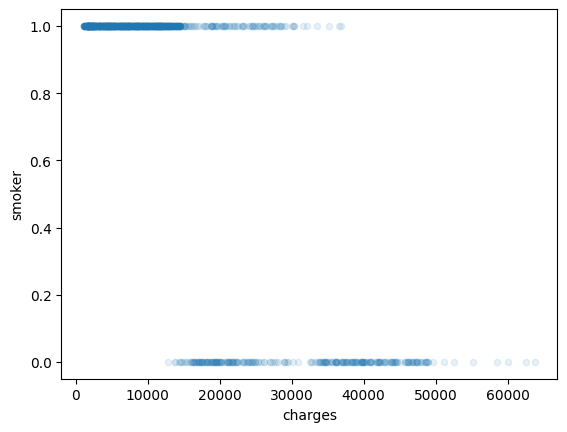

In [7]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Your code goes here for this section.

# Discovery
insurance_df = pd.read_csv(file_path)

modified_cat_insurance_df = insurance_df.copy(deep=True)

c = 0
countMale = 0
countFemale = 0
smoker = 0
nonsmoker = 0
for column in modified_cat_insurance_df:
    for index, value in modified_cat_insurance_df[column].items():
        if value == "male":
            modified_cat_insurance_df.iloc[index,c] = 0
            countMale += 1
        elif value == "female":
            modified_cat_insurance_df.iloc[index,c] = 1
            countFemale += 1
        elif value == "yes":
            modified_cat_insurance_df.iloc[index,c] = 0
            smoker += 1
        elif value == "no":
            modified_cat_insurance_df.iloc[index,c] = 1
            nonsmoker += 1
        elif value == "northeast":
            modified_cat_insurance_df.iloc[index,c] = 0
        elif value == "southeast":
            modified_cat_insurance_df.iloc[index,c] = 1
        elif value == "southwest":
            modified_cat_insurance_df.iloc[index,c] = 2
        elif value == "northwest":
            modified_cat_insurance_df.iloc[index,c] = 3
    c+=1

insurance_corr = modified_cat_insurance_df.corr()
index_labels = insurance_corr["charges"].sort_values(ascending=False).index

c = 0
for feature in insurance_corr["charges"].sort_values(ascending=False):
  if c != 0:
    modified_cat_insurance_df.plot(kind="scatter", x="charges", y=index_labels[c], alpha=0.1)
  c+=1

totalPeople = countMale + countFemale
print("The male count is " + str(countMale) + " (" + str((countMale/totalPeople)*100)+"%)" + " and female is "  + str(countFemale) + " (" + str((countFemale/totalPeople)*100)+"%)")

print("The smoker count is " + str(smoker) + " (" + str((smoker/totalPeople)*100)+"%)" + " and nonsmoker is "  + str(nonsmoker) + " (" + str((nonsmoker/totalPeople)*100)+"%)")


#Pipeline

train_set, test_set = train_test_split(insurance_df, test_size=0.2, random_state=42)

train_charges = train_set["charges"].copy()
train_set = train_set.drop("charges", axis=1)
test_charges = test_set["charges"].copy()
test_set = test_set.drop("charges", axis=1)


categories = ["sex", "smoker", "region"]
numerical_train = train_set.drop(categories, axis=1)

num_pipeline = Pipeline([
  ('std_scaler', StandardScaler()),
])

final_pipeline = ColumnTransformer([
    ("num", num_pipeline, list(numerical_train)),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categories),
])

insurance_prepared_train = final_pipeline.fit_transform(train_set)
insurance_prepared_test = final_pipeline.transform(test_set)

X_train = insurance_prepared_train
y_train = train_charges
X_test = insurance_prepared_test
y_test = test_charges

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods.

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [121]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation
import numpy as np
import math
class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = []; # parameter vector;
    self.alpha = []; # learning rate
    self.cost  = []; # cost function

  def fitUsingGradientDescent(self, X_train, y_train, alpha, iters):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    X_mod = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    local_theta = np.random.randn(X_train.shape[1] + 1,1)
    retTheta, retCost = self.gradientDescent(X_mod, y_train, local_theta, alpha, iters)
    self.theta = retTheta
    self.cost = retCost



  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    X_mod = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    transpose = X_mod.T
    dot = transpose.dot(X_mod)
    linalge = np.linalg.pinv(dot)
    self.theta = linalge.dot(transpose).dot(y_train)
    # recomputeDotSub = X_mod.dot(theta) - y_train.values
    # self.cost = theta, np.sqrt((recomputeDotSub ** 2).mean())


  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT:
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    m = len(X_train)
    for i in range(iters):
      transpose = X_train.T
      dot = X_train.dot(theta)
      subtract = dot - y_train.values
      cost = (2/m) * transpose.dot(subtract)
      theta = theta - alpha * cost
    recomputeDotSub = X_train.dot(theta) - y_train.values
    return theta, np.sqrt((recomputeDotSub ** 2).mean())

  def predict(self, X_test):
    """
    Predicting the label
    """
    # implementation code here
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    # implement here to return("Parameter vector is %f" % self.theta)   }

# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train, .1, 100)
print(myGradientDescentModel.theta)
myGradientDescentModel.cost

#myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)

[[ 4.08516293e+03  3.79227048e+03  1.20495363e+04 ...  5.30144193e+03
   2.04899559e+04  4.53874148e+03]
 [-7.12524316e-02 -6.61629856e-02 -2.09645374e-01 ... -9.23871050e-02
  -3.56310335e-01 -7.91340398e-02]
 [-4.61490981e-01 -4.28232074e-01 -1.36587194e+00 ... -5.99603488e-01
  -2.32430953e+00 -5.12996327e-01]
 ...
 [ 1.01906704e+03  9.45973754e+02  3.00663001e+03 ...  1.32259765e+03
   5.11299353e+03  1.13226062e+03]
 [ 1.02350896e+03  9.50096080e+02  3.01976252e+03 ...  1.32836675e+03
   5.13533606e+03  1.13719748e+03]
 [ 1.01985902e+03  9.46708088e+02  3.00898970e+03 ...  1.32362904e+03
   5.11701462e+03  1.13314188e+03]]


5.826067089956798

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

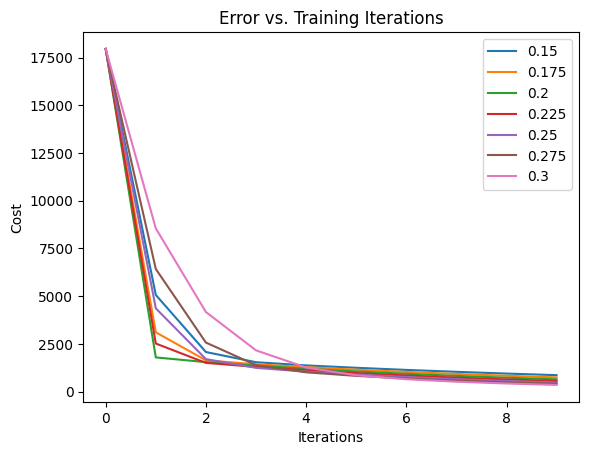

In [112]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.

#I started with iterations = [0 - 1000 by 100s]. This was way too much and made the cost be very low.
#Then I tried a range of rates from 0 to .99, which also skewed the graph by a lot
#Eventually after shaving off values that skewed the graph from either end, and rescaling the values. I ended up with the below values


iterations = [x for x in range(0,10,1)]

learningRates = [.15, .175, .2, .225, .25, .275, .3]

gradDes = MyLinearRegression()

for rate in learningRates:
    costsForRate = []
    bestRate = bestRateOverall
    for iter in iterations:
        gradDes.fitUsingGradientDescent(X_train, y_train, rate, iter)
        costsForRate.append(gradDes.cost)
    plt.plot(iterations, costsForRate, label=(rate))

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Error vs. Training Iterations')
plt.legend()
plt.show()

# I found that the learning rate .225 converges very quickly and converges closer to the true value than some other options that may converges more quickly, but further from the true value.

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement:

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [122]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [ ]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
#mySGDModel.fit(X_train,y_train)
#y_predict = mySGDModel.predict(X_test)
#mse = mean_squared_error(y_test, y_predict)
#mySGDModel_rmse = np.sqrt(mse)
# print(mySGDModel_rmse)

# myGradientDescentModel_rmse
# myNormalEquationModel_rmse



- - -
## Task 6. PRESENT YOUR SOLUTION

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following:

* How can you pitch your solution to this project?
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [ ]:
# Your paragraph goes here for this section

- - -
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!